# Bayesian Assignment of State

In [1]:
import os
import numpy as np 
import pandas as pd
import arviz as az
import warnings
import spc_os
import pickle
import cellbell
import seaborn as sns
import cellbell
import matplotlib.pyplot as plt
from scipy.stats import halfcauchy, skewnorm, norm
import sys
sys.path.append("..")
from src.visualization.handle_data import combine_posterior_variables
#cpu or cuda
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float64'
import pymc3 as pm
RANDOM_SEED = 281090
warnings.filterwarnings("ignore")

In [2]:
raw_data_dir = '../data/raw/'
interim_data_dir = '../data/interim/'
processed_data_dir = '../data/processed/'
external_data_dir = '../data/external/'
models_dir = '../models/bayesian/'
reports_dir = '../reports/'

In [3]:
%mkdir ../models/bayesian

mkdir: cannot create directory ‘../models/bayesian’: File exists


In [4]:
with open('../data/aa_resid_dic.pkl', 'rb') as my_file:
    aa_dic = pickle.load(my_file)

## Set-up parameters

In [6]:
method = 'sparta_plus'
nucleus = 'CA'
data_size = 1000  # 70000 max data_size
model_name = 'normal_model'
infer = True
critique = True

## Load and prepare data

Mask according to nuclei present in all 3 experimental states. Sample part of the data and select the nucleus.

In [7]:
df_diff = pd.read_pickle(processed_data_dir + 'diff_CS.pkl')

In [8]:
mask = df_diff.dropna(axis=1).columns

In [9]:
df_diff = df_diff.loc[:, mask].xs(nucleus, level='nuclei', axis=1)

In [10]:
df_exp_o = pd.read_pickle(processed_data_dir + 'open_CS.pkl')

In [11]:
df_exp_o = df_exp_o.loc[:, mask].xs(nucleus, level='nuclei', axis=1)

In [12]:
df_3fb5 = pd.read_pickle(processed_data_dir +
                         f'3FB5_lb/CS_{method}_3FB5_lb.pkl')

In [13]:
df_3fb5 = df_3fb5.loc[:, mask].sample(data_size,
                                      random_state=RANDOM_SEED)
df_3fb5 = df_3fb5.xs(nucleus, level='nuclei', axis=1)

In [14]:
df_5vk6 = pd.read_pickle(processed_data_dir +
                         f'5VK6_lb/CS_{method}_5VK6_lb.pkl')

In [15]:
df_5vk6 = df_5vk6.loc[:, mask].sample(data_size,
                                      random_state=RANDOM_SEED)
df_5vk6 = df_5vk6.xs(nucleus, level='nuclei', axis=1)

In [16]:
df_5vkh = pd.read_pickle(processed_data_dir +
                         f'5VKH_lb/CS_{method}_5VKH_lb.pkl')

In [17]:
df_5vkh = df_5vkh.loc[:, mask].sample(data_size,
                                      random_state=RANDOM_SEED)
df_5vkh = df_5vkh.xs(nucleus, level='nuclei', axis=1)

In [18]:
df_5vke = pd.read_pickle(processed_data_dir +
                         f'5VKE_lb/CS_{method}_5VKE_lb.pkl')

In [19]:
df_5vke = df_5vke.loc[:, mask].sample(data_size,
                                      random_state=RANDOM_SEED)
df_5vke = df_5vke.xs(nucleus, level='nuclei', axis=1)

In [20]:
coords = {
    'resid': [aa_dic[res] + str(res) for res in df_3fb5.columns],
    'step': df_3fb5.index
}

## Study Data

Some notes:
+ Fast exchange: 33,38, 71, 85, 107
+ One SU different: 61
+ Assymettrical subunits: 44, 51
+ Change during trajectory: 69
+ Homogeneous: Rest

### Histograms

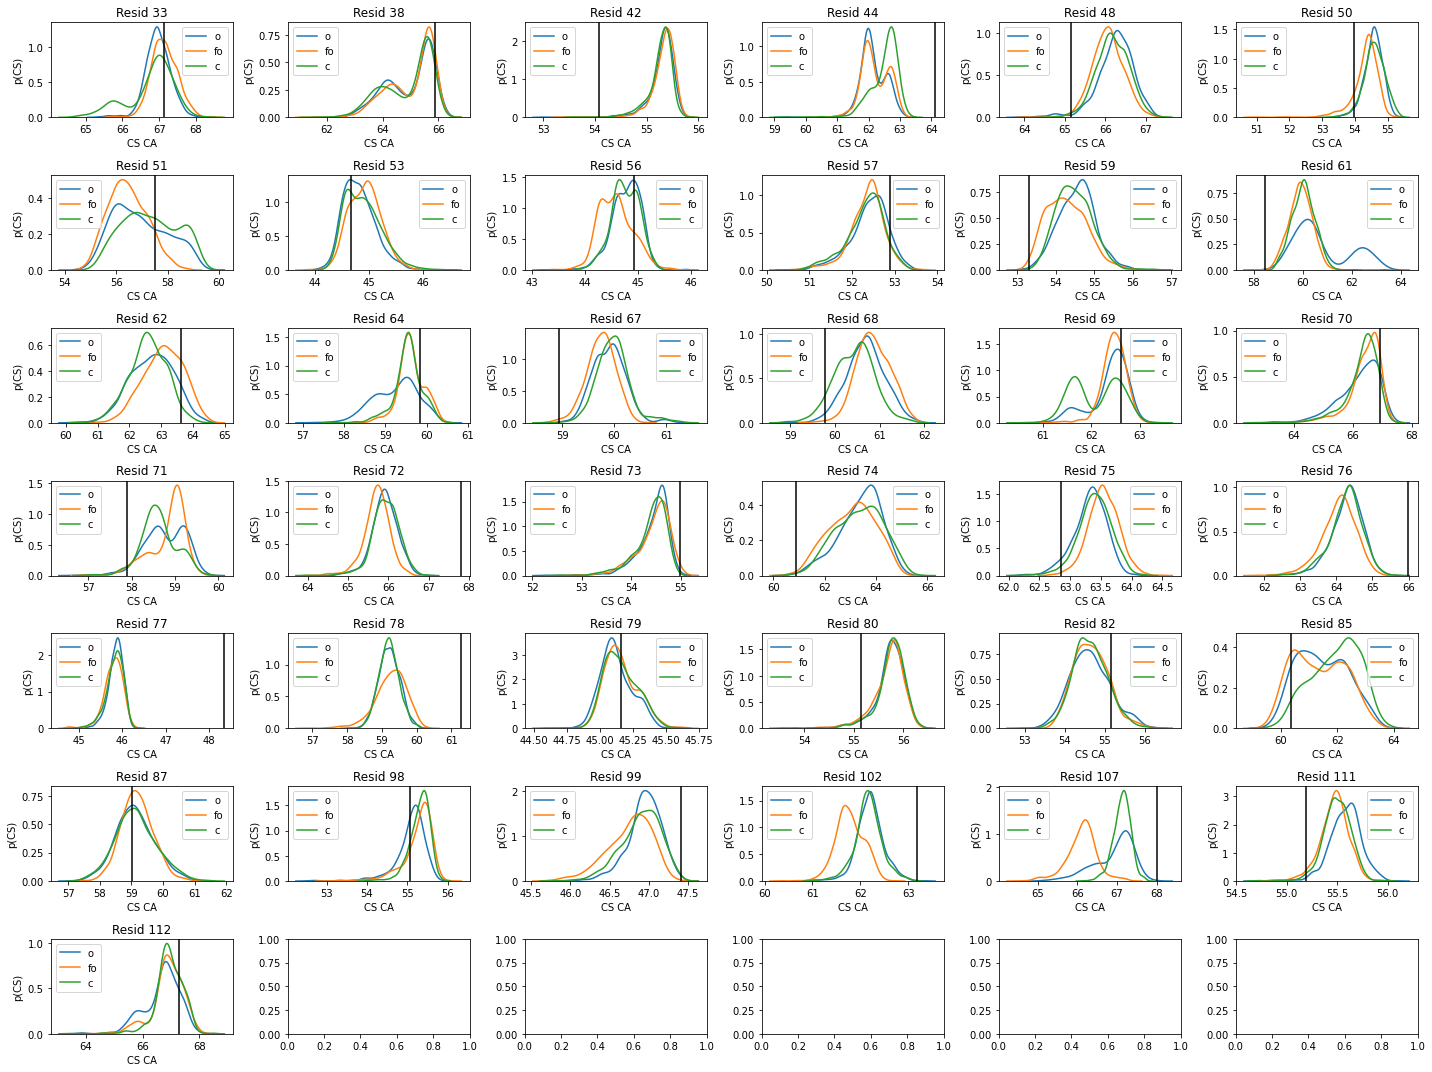

In [21]:
fig, ax = plt.subplots(df_3fb5.shape[1] // 6 + 1, 6, figsize=(20, 15))
ax = ax.flatten()
for i, resid in enumerate(df_3fb5):
    sns.kdeplot(df_3fb5[resid], ax=ax[i], label='o')
    sns.kdeplot(df_5vk6[resid], ax=ax[i], label='fo')
    sns.kdeplot(df_5vkh[resid], ax=ax[i], label='c')
    ax[i].set_title(f'Resid {resid}')
    ax[i].set_xlabel(f'CS {nucleus}')
    ax[i].set_ylabel('p(CS)')
    ax[i].axvline(x=df_exp_o[resid][0], c="black")
    ax[i].legend()
fig.tight_layout()
fig.savefig(reports_dir + f'hist_{method}_{nucleus}.png')

### Time series

#### Closed

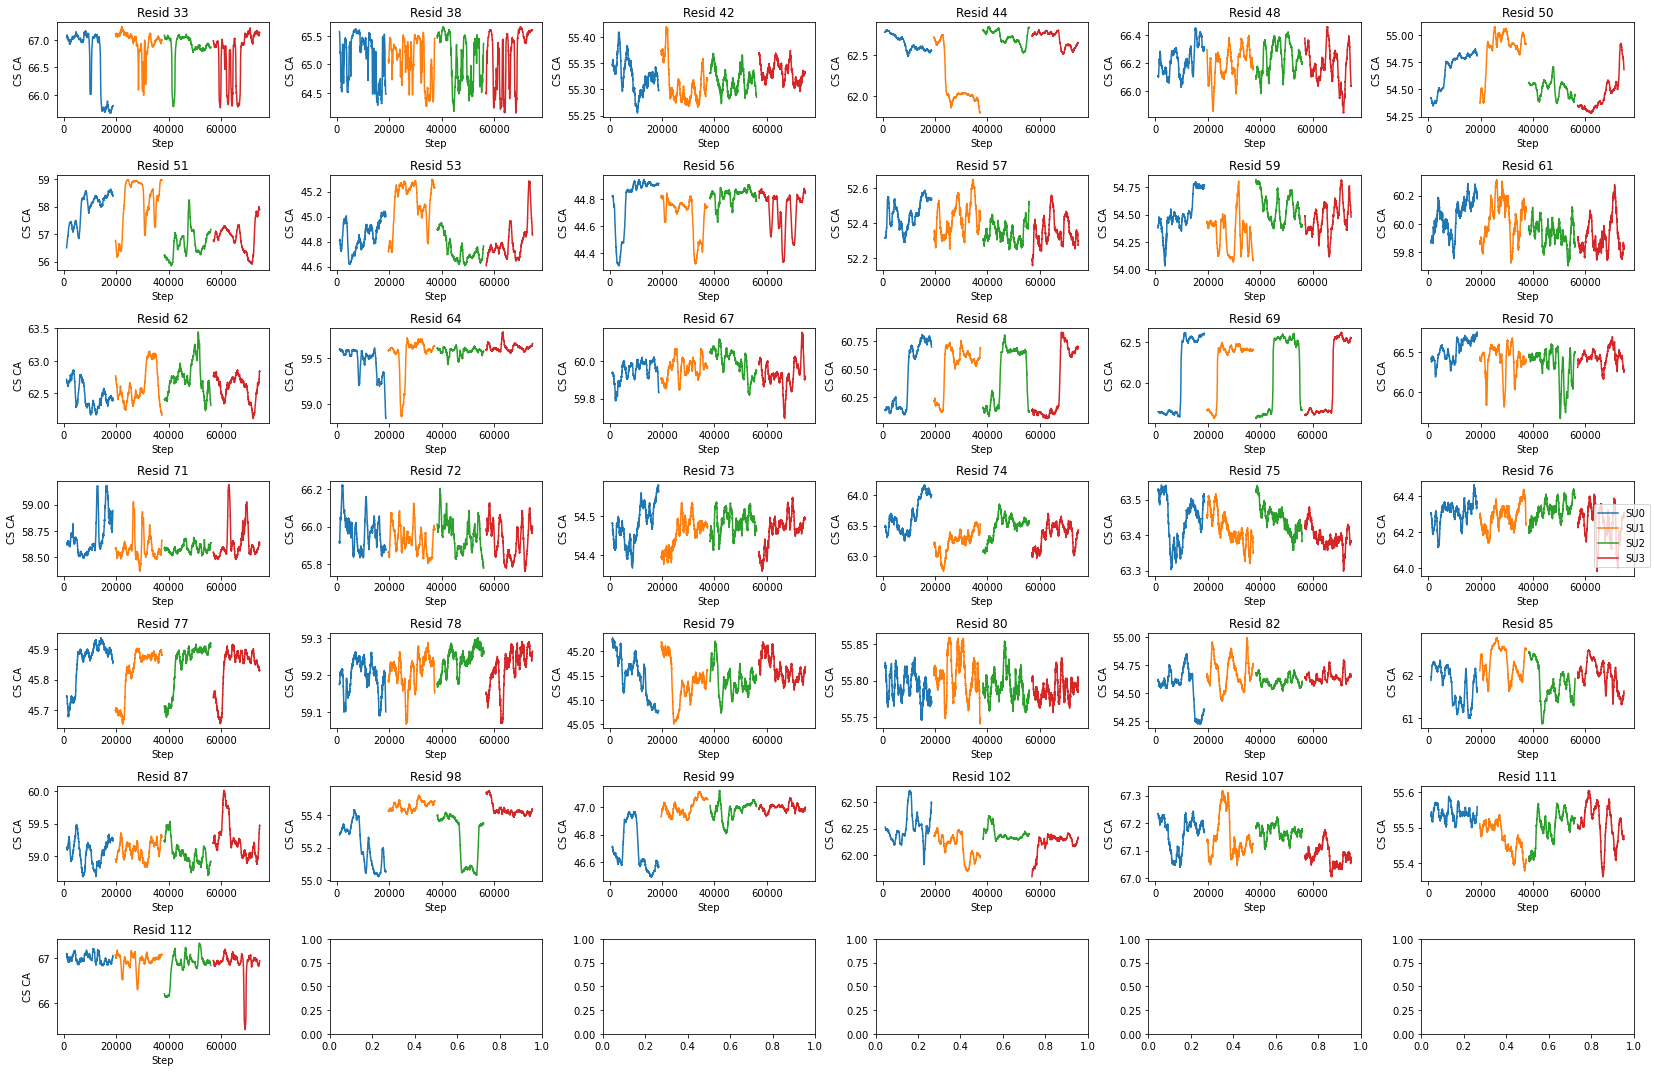

In [22]:
state = '5VKH_lb'
df = pd.read_pickle(f'{processed_data_dir}{state}/CS_{method}_{state}.pkl')
df = df.loc[:, mask].xs(nucleus, level='nuclei', axis=1)
n_roll = 1000
fig, ax = plt.subplots(df.shape[1] // 6 + 1, 6, figsize=(23, 15))
ax = ax.flatten()
for i, resid in enumerate(df):
    for j, split in enumerate(np.split(df[resid], 4)):
        y = split.rolling(n_roll).median()[n_roll:]
        ax[i].plot(y, label=f'SU{j}')
    ax[i].set_title(f'Resid {resid}')
    ax[i].set_ylabel(f'CS {nucleus}')
    ax[i].set_xlabel('Step')
handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.savefig(reports_dir + f'time_series_{method}_{nucleus}_{state}.png')
del df

#### Open

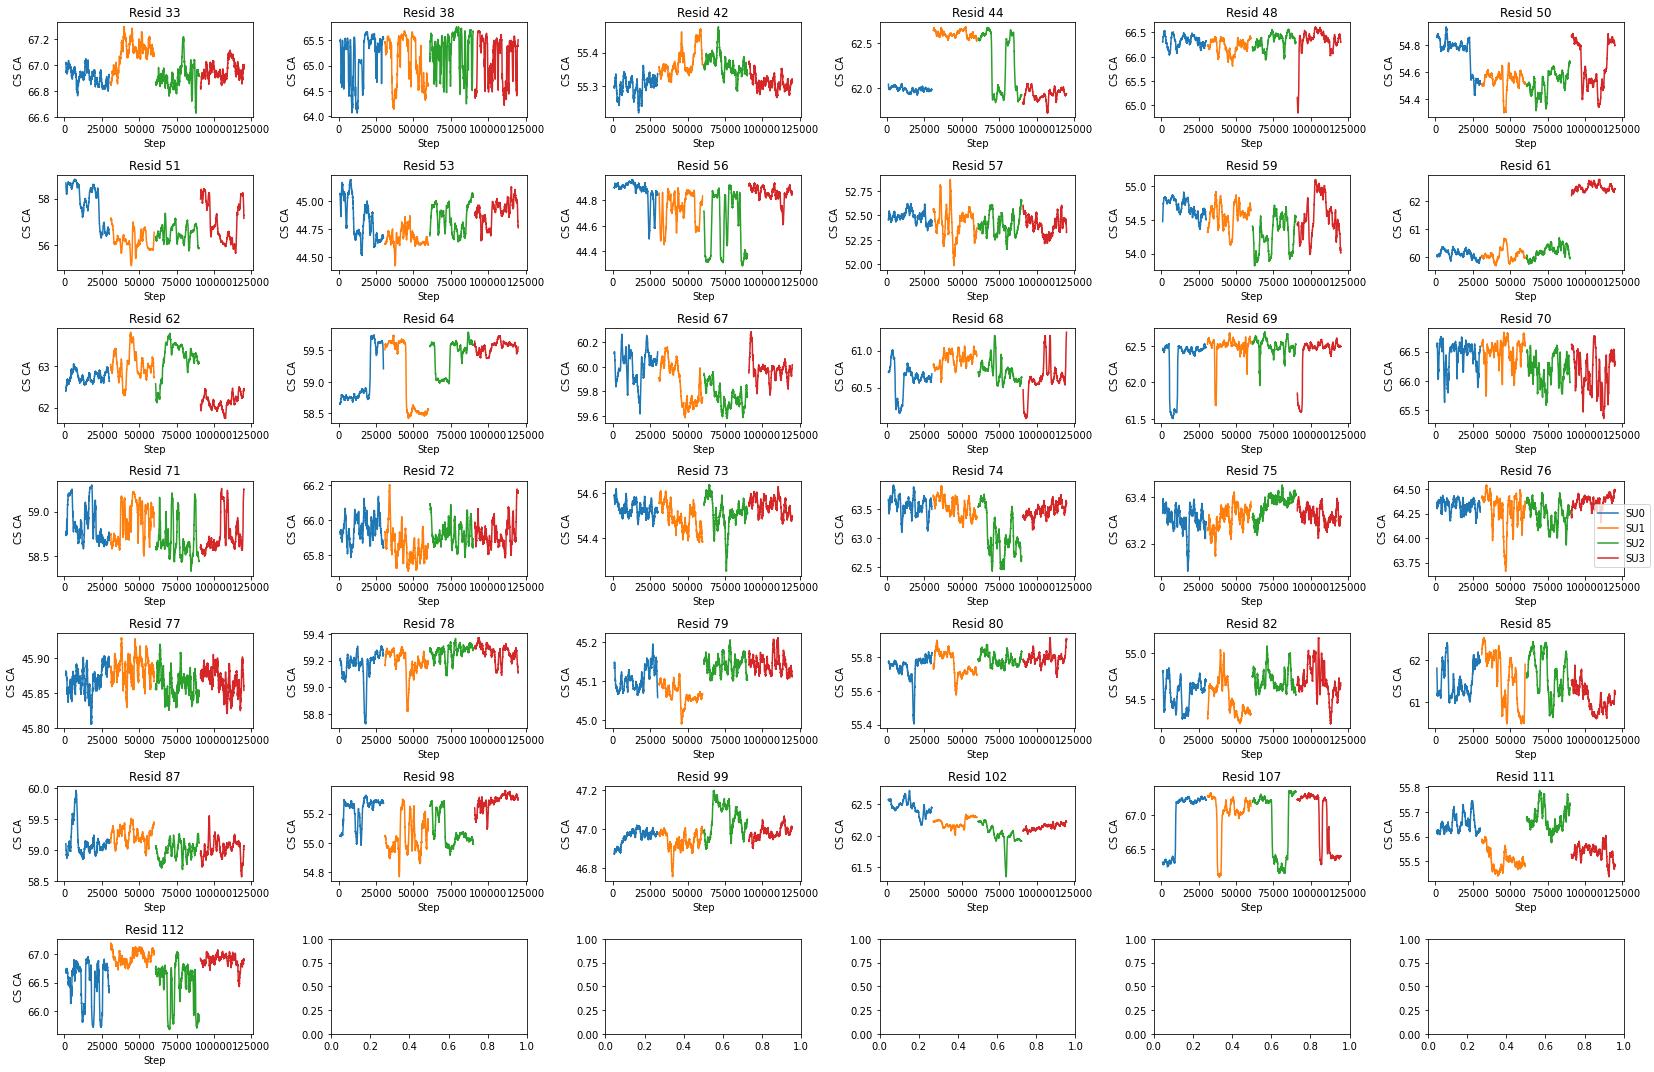

In [23]:
state = '3FB5_lb'
df = pd.read_pickle(f'{processed_data_dir}{state}/CS_{method}_{state}.pkl')
df = df.loc[:, mask].xs(nucleus, level='nuclei', axis=1)
n_roll = 1000
fig, ax = plt.subplots(df.shape[1] // 6 + 1, 6, figsize=(23, 15))
ax = ax.flatten()
for i, resid in enumerate(df):
    for j, split in enumerate(np.split(df[resid], 4)):
        y = split.rolling(n_roll).median()[n_roll:]
        ax[i].plot(y, label=f'SU{j}')
    ax[i].set_title(f'Resid {resid}')
    ax[i].set_ylabel(f'CS {nucleus}')
    ax[i].set_xlabel('Step')
handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.savefig(reports_dir + f'time_series_{method}_{nucleus}_{state}.png')
del df

#### Fully Open

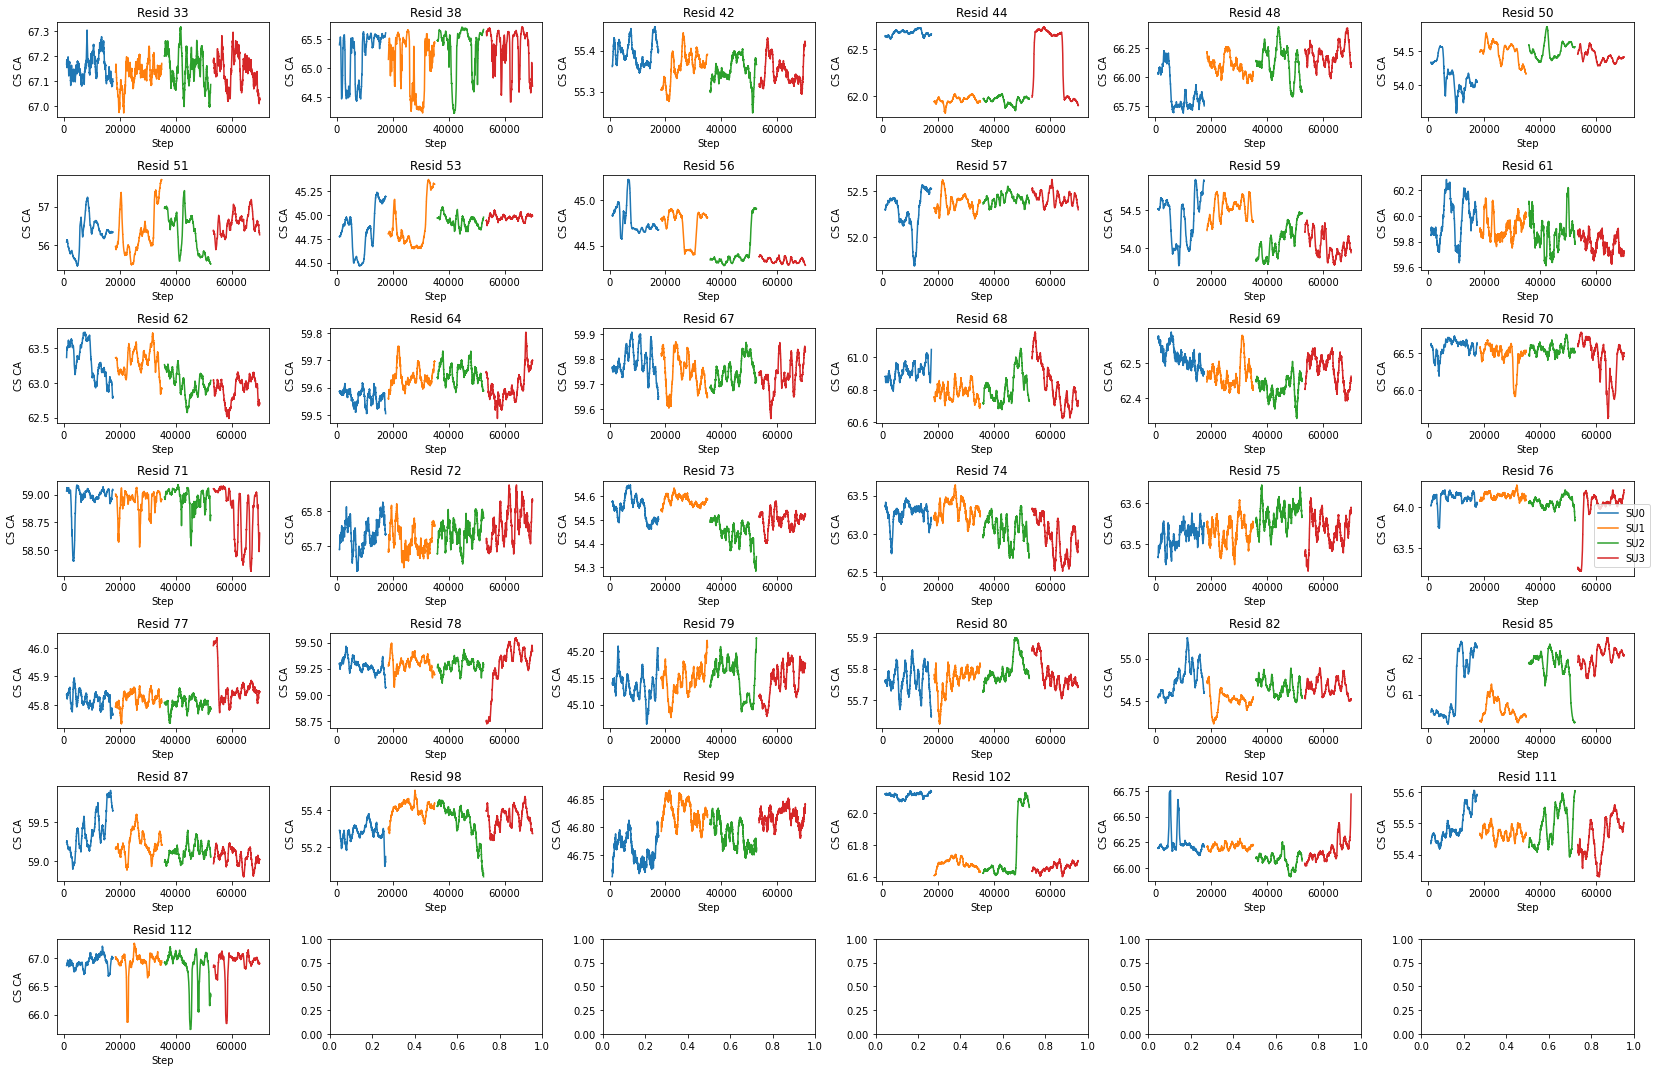

In [24]:
state = '5VK6_lb'
df = pd.read_pickle(f'{processed_data_dir}{state}/CS_{method}_{state}.pkl')
df = df.loc[:, mask].xs(nucleus, level='nuclei', axis=1)
n_roll = 1000
fig, ax = plt.subplots(df.shape[1] // 6 + 1, 6, figsize=(23, 15))
ax = ax.flatten()
for i, resid in enumerate(df):
    for j, split in enumerate(np.split(df[resid], 4)):
        y = split.rolling(n_roll).median()[n_roll:]
        ax[i].plot(y, label=f'SU{j}')
    ax[i].set_title(f'Resid {resid}')
    ax[i].set_ylabel(f'CS {nucleus}')
    ax[i].set_xlabel('Step')
handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.savefig(reports_dir + f'time_series_{method}_{nucleus}_{state}.png')
del df

## Model Data CA

In [25]:
if model_name == 'normal_model':
    beta_prior = 4
    sd_prior = 1
    diff_vector = df_diff.to_numpy().T
    with pm.Model(coords=coords) as my_model:
        mu_o = pm.Normal('mu_o', mu=df_3fb5.mean(), sd=sd_prior, dims='resid')
        sd_o = pm.HalfCauchy('sd_o', beta=beta_prior, dims='resid')
        mu_fo = pm.Normal('mu_fo', mu=df_5vk6.mean(), sd=sd_prior, dims='resid')
        sd_fo = pm.HalfCauchy('sd_fo', beta=beta_prior, dims='resid')
        mu_c = pm.Normal('mu_c', mu=df_5vkh.mean(), sd=sd_prior, dims='resid')
        sd_c = pm.HalfCauchy('sd_c', beta=beta_prior, dims='resid')

        # Define the likelihood.
        like_o = pm.Normal('like_o',
                           mu=mu_o,
                           sd=sd_o,
                           observed=df_3fb5,
                           dims=('step', 'resid')
                           )
        like_fo = pm.Normal('like_fo',
                            mu=mu_fo,
                            sd=sd_fo,
                            observed=df_5vk6,
                            dims=('step', 'resid')
                            )
        like_c = pm.Normal('like_c',
                           mu=mu_c,
                           sd=sd_c,
                           observed=df_5vkh,
                           dims=('step', 'resid')
                           )
        diff_means = pm.Deterministic('diff_means', mu_o - mu_fo, dims='resid')
        mu_o_c = pm.Deterministic('mu_o_c', mu_o - mu_c, dims='resid') - diff_vector
        mu_fo_c = pm.Deterministic('mu_fo_c', mu_fo - mu_c, dims='resid') - diff_vector
        pooled_sd = np.sqrt(np.power(sd_o, 2) + np.power(sd_fo, 2) / (2))
        effect_size = pm.Deterministic('effect_size',
                                       diff_means / pooled_sd, dims='resid')
    model_path = models_dir + f"{model_name}_{method}_{nucleus}.nc"

In [26]:
%%time
%%ding
if infer:
    with my_model:
        my_model_trace = pm.sample(2000, tune=1000, random_seed=RANDOM_SEED, return_inferencedata=False)
        ppc = pm.sample_posterior_predictive(my_model_trace, var_names=["like_fo","like_o","like_c"], random_seed=RANDOM_SEED)
    my_model_trace = az.from_pymc3(trace=my_model_trace, model=my_model, posterior_predictive=ppc)
    print('Done infering.')
    spc_os.remove(model_path)
    my_model_trace.to_netcdf(model_path)
    print('Done saving.')
    del ppc

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_c, mu_c, sd_fo, mu_fo, sd_o, mu_o]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 69 seconds.


Done infering.
Done saving.
CPU times: user 6min 10s, sys: 18.6 s, total: 6min 29s
Wall time: 8min 5s


## Critize model 

In [27]:
my_model_trace = az.from_netcdf(model_path)

In [28]:
spc_os.mkdir(reports_dir + f'critique/{model_name}_{method}_{nucleus}')

### Point Summaries

Check that r_hat is approx 1 and that ess_mean is near to the number of steps.

In [29]:
if critique:
    df_summary = az.summary(my_model_trace)
    with pd.option_context('display.max_rows', None):
        print(df_summary)

                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu_o[0]          66.968  0.011  66.949   66.988        0.0    0.000   15679.0   
mu_o[1]          64.964  0.027  64.913   65.014        0.0    0.000   15206.0   
mu_o[2]          55.297  0.008  55.283   55.311        0.0    0.000   14406.0   
mu_o[3]          62.152  0.013  62.128   62.176        0.0    0.000   15188.0   
mu_o[4]          66.254  0.014  66.227   66.280        0.0    0.000   15727.0   
mu_o[5]          54.566  0.009  54.549   54.582        0.0    0.000   13822.0   
mu_o[6]          56.943  0.034  56.881   57.010        0.0    0.000   14868.0   
mu_o[7]          44.824  0.009  44.806   44.841        0.0    0.000   14827.0   
mu_o[8]          44.777  0.009  44.761   44.793        0.0    0.000   13574.0   
mu_o[9]          52.408  0.014  52.381   52.433        0.0    0.000   15032.0   
mu_o[10]         54.555  0.015  54.527   54.582        0.0    0.000   15675.0   
mu_o[11]         60.760  0.0

### Plot Traces (Posteriors)

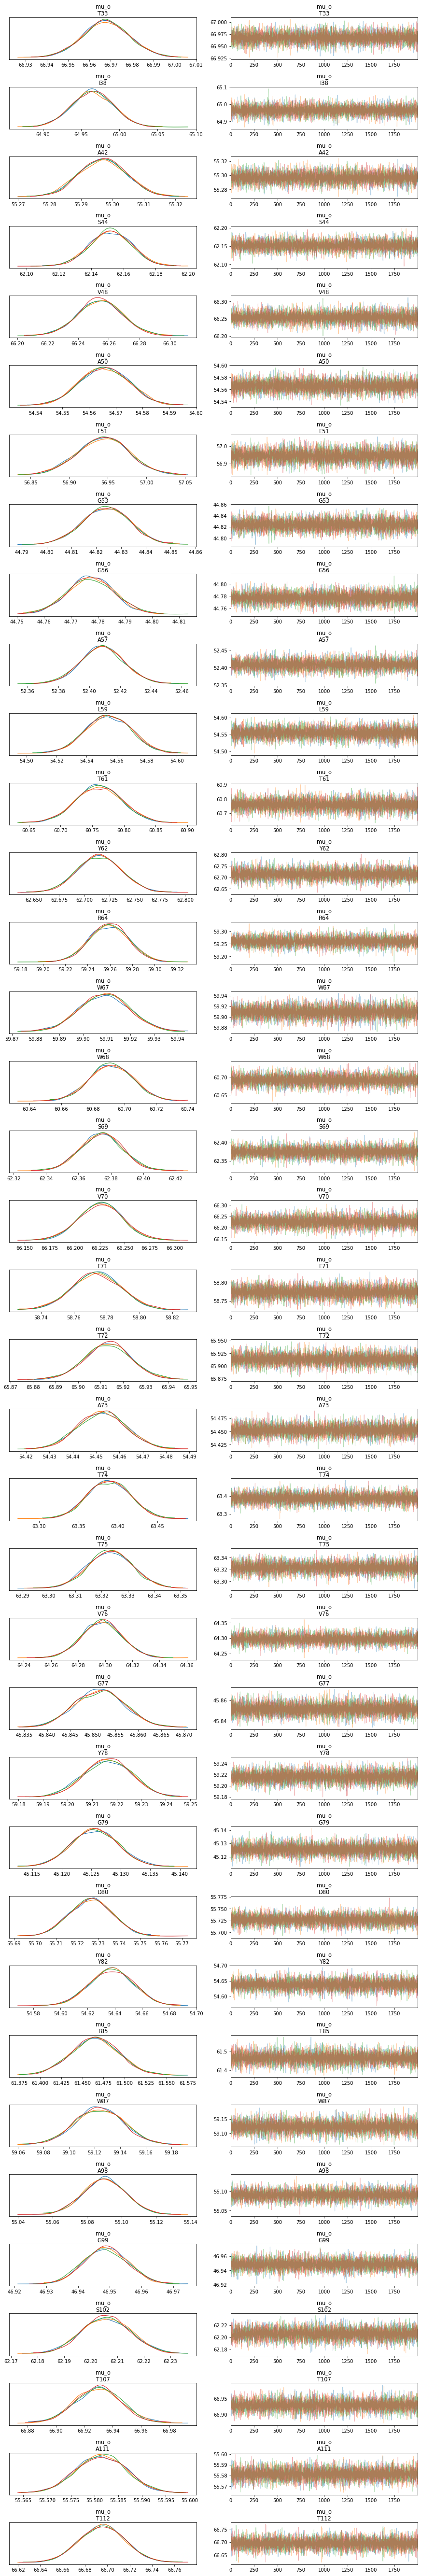

In [29]:
if critique:
    magnitude = 'mu_o'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    fig.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'mu_fo'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    fig.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'mu_c'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    fig.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'sd_o'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    fig.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'sd_fo'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    fig.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'sd_c'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    fig.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

### Autocorrelations

In [ ]:
if critique:
    magnitude = 'mu_o'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    fig.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'mu_fo'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    fig.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'mu_c'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    fig.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'sd_o'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    fig.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'sd_fo'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    fig.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'sd_c'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    fig.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

### Posterior Predictive Test

### PPC Open

In [ ]:
if critique:
    state = 'o'
    az.plot_ppc(my_model_trace, flatten=['step'], var_names = [f'like_{state}'], random_seed=RANDOM_SEED)
    plt.savefig(f'{reports_dir}critique/{model_name}_{method}_{nucleus}/ppc_{state}.png')

### PPC Fully Open

In [ ]:
if critique:
    state = 'fo'
    az.plot_ppc(my_model_trace, flatten=['step'], var_names = [f'like_{state}'], random_seed=RANDOM_SEED)
    plt.savefig(f'{reports_dir}critique/{model_name}_{method}_{nucleus}/ppc_{state}.png')

### PPC Closed

In [ ]:
if critique:
    state = 'c'
    az.plot_ppc(my_model_trace, flatten=['step'], var_names = [f'like_{state}'], random_seed=RANDOM_SEED)
    plt.savefig(f'{reports_dir}critique/{model_name}_{method}_{nucleus}/ppc_{state}.png')

## Investigate

In [41]:
my_model = az.from_netcdf(model_path)

In [42]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['mu_o', 'mu_fo', 'mu_c'], 'mu', 'state',
    ['o', 'fo', 'c'])

In [43]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['sd_o', 'sd_fo', 'sd_c'], 'sd', 'state',
    ['o', 'fo', 'c'])

In [44]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['mu_o_c', 'mu_fo_c'], 'mu_ref', 'state',
    ['o', 'fo'])

### Difference in CS

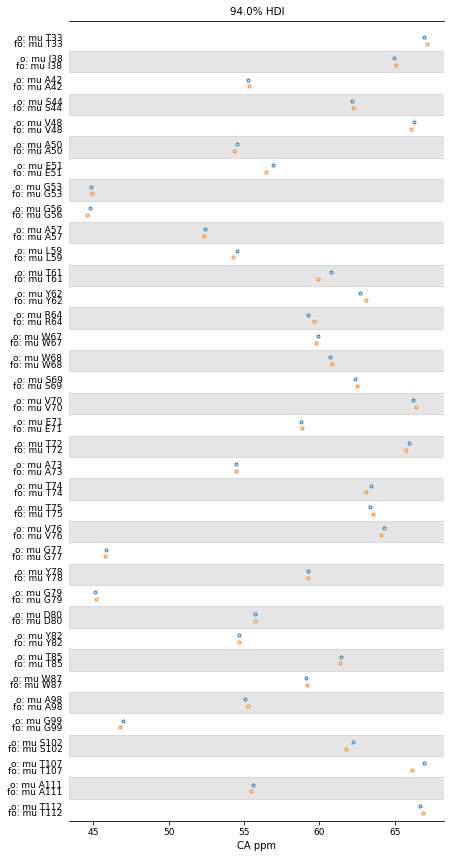

In [45]:
az.plot_forest(
    (my_model.sel(state="o"), my_model.sel(state="fo")),
    var_names="mu",
    combined=True,
    colors=["C0", "C1"],
    model_names=["o", "fo"],
    textsize=9,
    figsize=(7, 15),
)
plt.xlabel(f'{nucleus} ppm')
plt.savefig(f'{reports_dir}figures/mu_{model_name}_{method}_{nucleus}.png')
plt.tight_layout()

### Which signals are statistically different in o/fo

Big differences:
+ CA: A50, E51, L59, T61, T74, V76, S102, T107

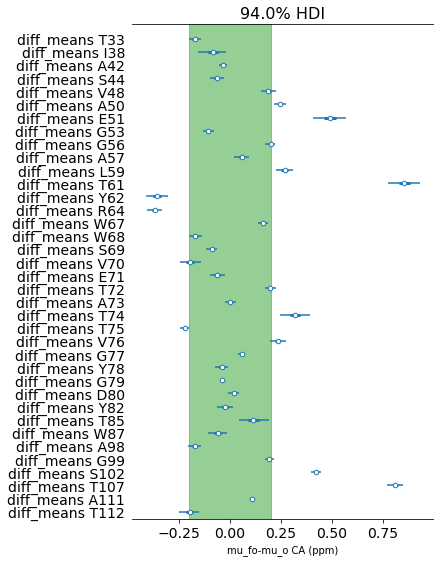

In [35]:
az.plot_forest(my_model.posterior, rope=(-0.2, 0.2), combined=True,
              var_names=['diff_means'])
plt.xlabel(f'mu_fo-mu_o {nucleus} (ppm)')
plt.savefig(f'{reports_dir}figures/diff_mu_{model_name}_{method}_{nucleus}.png')

Medium/Big Differences Sizes:
+ CA: A50, E51, L59, T61, T74, V76, S102, T107

Medium/Big Effect Sizes:
+ CA: A50, G56, T61, R64, T75, G99, S102, T107, A111

Common:
+ CA: A50, T61, S102, T107

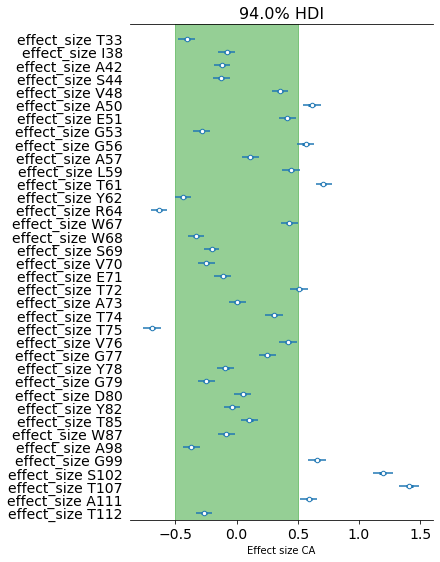

In [49]:
az.plot_forest(my_model, combined=True, var_names=['effect_size'], rope=(-0.5, 0.5))
plt.xlabel(f'Effect size {nucleus}')
plt.savefig(f'{reports_dir}figures/effect_size_{model_name}_{method}_{nucleus}.png')

### Assignment

In [54]:
studied_res = ['A50', 'T61', 'S102', 'T107']

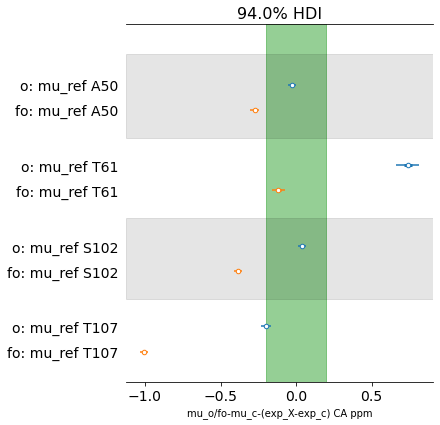

In [55]:
az.plot_forest(
    (my_model.posterior.sel(state="o"), my_model.posterior.sel(state="fo")),
    var_names="mu_ref",
    combined=True,
    colors=["C0", "C1"],
    model_names=["o", "fo"],
    rope=(-0.2, 0.2),
    coords={'resid': studied_res}
)
plt.xlabel(f'mu_o/fo-mu_c-(exp_X-exp_c) {nucleus} ppm')
plt.savefig(f'{reports_dir}figures/assignment_{model_name}_{method}_{nucleus}.png')

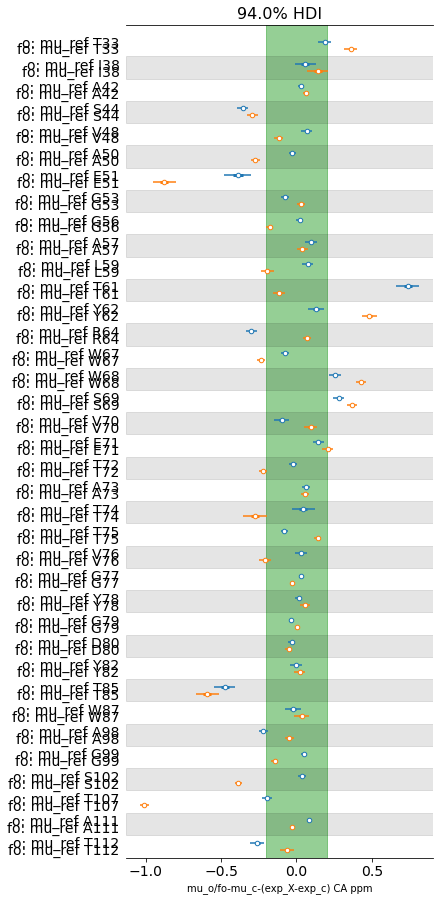

In [56]:
az.plot_forest(
    (my_model.posterior.sel(state="o"), my_model.posterior.sel(state="fo")),
    var_names="mu_ref",
    combined=True,
    colors=["C0", "C1"],
    model_names=["o", "fo"],
    rope=(-0.2, 0.2),
    #coords={'resid': studied_res}
)
plt.xlabel(f'mu_o/fo-mu_c-(exp_X-exp_c) {nucleus} ppm')
plt.savefig(f'{reports_dir}figures/assignment_all_{model_name}_{method}_{nucleus}.png')

## Debugging